In [1]:
# Step 1: Install dependencies
!pip install cvzone opencv-python-headless --quiet


  Preparing metadata (setup.py) ... done


In [2]:
# Step 2: Upload image and CarParkPos file
from google.colab import files
uploaded = files.upload()


Saving CarParkPos to CarParkPos
Saving parking.jpg to parking.jpg


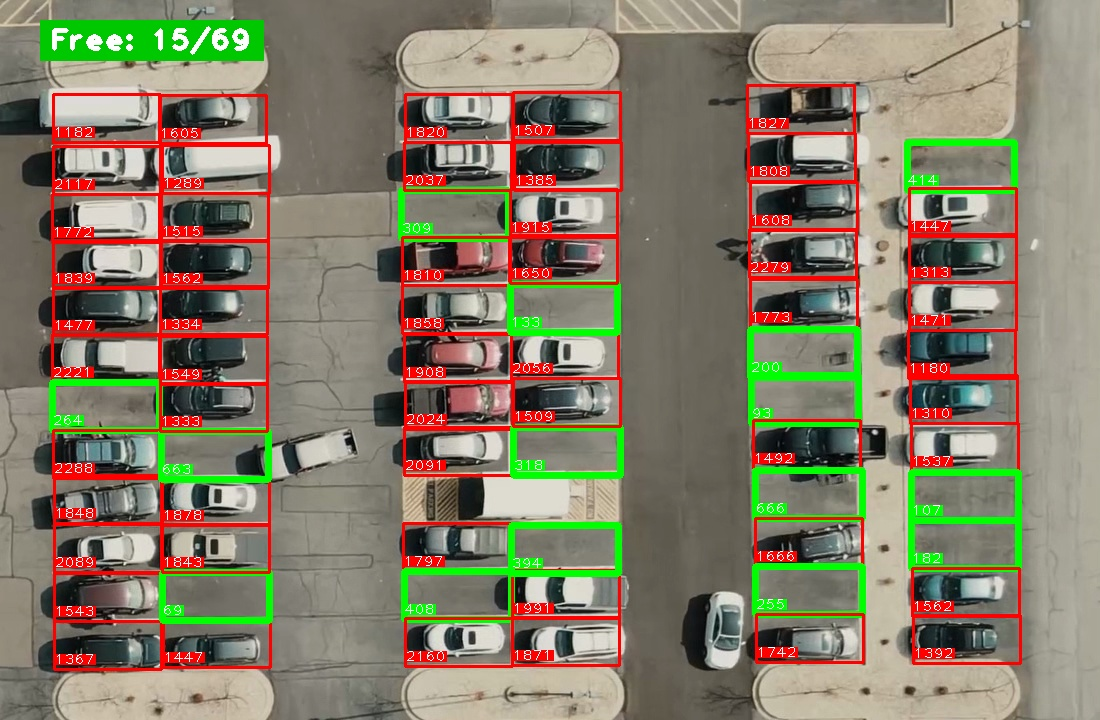

In [3]:
# Step 3: Parking spot detection from image

import cv2
import pickle
import numpy as np
import cvzone
from PIL import Image
import io
from IPython.display import display

# Replace this with the name of your uploaded image file
image_path = next(filename for filename in uploaded if filename.endswith(('.jpg', '.png')))
posList_path = next(filename for filename in uploaded if 'CarParkPos' in filename)

# Load image
img = cv2.imread(image_path)

# Load spot coordinates
with open(posList_path, 'rb') as f:
    posList = pickle.load(f)

# Spot rectangle size
width, height = 107, 48

def checkParkingSpace(imgPro, imgDraw):
    spaceCounter = 0

    for pos in posList:
        x, y = pos
        imgCrop = imgPro[y:y+height, x:x+width]
        count = cv2.countNonZero(imgCrop)

        if count < 900:
            color = (0, 255, 0)
            thickness = 5
            spaceCounter += 1
        else:
            color = (0, 0, 255)
            thickness = 2

        cv2.rectangle(imgDraw, pos, (x + width, y + height), color, thickness)
        cvzone.putTextRect(imgDraw, str(count), (x, y + height - 5), scale=1, thickness=1, offset=0, colorR=color)

    cvzone.putTextRect(imgDraw, f"Free: {spaceCounter}/{len(posList)}", (50, 50), scale=2, thickness=3, offset=10, colorR=(0, 200, 0))

# Preprocessing image
imgGray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
imgBlur = cv2.GaussianBlur(imgGray, (3, 3), 1)
imgThresh = cv2.adaptiveThreshold(imgBlur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                  cv2.THRESH_BINARY_INV, 25, 16)
imgMedian = cv2.medianBlur(imgThresh, 5)
kernel = np.ones((3, 3), np.uint8)
imgDilate = cv2.dilate(imgMedian, kernel, iterations=1)

checkParkingSpace(imgDilate, img)

# Convert to display in notebook
_, img_encoded = cv2.imencode('.jpg', img)
img_display = Image.open(io.BytesIO(img_encoded.tobytes()))
display(img_display)
